In [2]:
import os
import glob 
import numpy as np
import pandas as pd 
import scanpy as sc
import seaborn as sns

In [218]:
def atLeastOnce( N, k, n ):
    p0 = (1-k/N)**n 
    p1 = n * (1-k/N)**(n-1) * (k/N)
    return (1 - p0 - p1 ) * N

13009.632749872895

## Load h5ad for each dataset

In [2]:
adata_SG1 = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/1_raw_h5ad/Joanito.CRC-SG1.raw.h5ad')
adata_KUL = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/1_raw_h5ad/Joanito.KUL-MSI.raw.h5ad')
adata_Chen = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/1_raw_h5ad/Chen.MSI.raw.h5ad')

Match columns for Joanito data ({'Response', 'TMB', 'TreatmentStage'})

In [3]:
adata_SG1.obs['Response']   = 'N/A'
adata_SG1.obs['TMB']        = 'N/A'
adata_SG1.obs['TreatmentStage'] = 'N/A'

adata_KUL.obs['Response']   = 'N/A'
adata_KUL.obs['TMB']        = 'N/A'
adata_KUL.obs['TreatmentStage'] = 'N/A'

adata_SG1.obs['dataset'] = 'Joanito-SG1'
adata_KUL.obs['dataset'] = 'Joanito-KUL'
adata_Chen.obs['dataset'] = 'Chen'

## Label cell type

### Joanito et al (both KUL and SG1)

In [116]:
joanito_metadata_epi    = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/synapse-metadata/Epithelial_metadata.csv')
joanito_metadata_nonepi = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/synapse-metadata/NonEpithelial_metadata.csv')
joanito_metadata = pd.concat([ joanito_metadata_epi, joanito_metadata_nonepi ])

joanito_metadata = joanito_metadata[(joanito_metadata['patient.ID'].isin( ['CRC2783', 'CRC2817', 'SC035', 'SC044'] ))].copy()
joanito_metadata.rename({'sample.origin' : 'BiopsySite'}, axis=1, inplace=True)
joanito_metadata['CB'] = [ cellID.split("_")[-1].split("-")[0] for cellID in joanito_metadata['cell.ID'] ]

Strangely, Joanito metadata provides a weird set of Sample ID.. So we have to manually find out which sample match to which sample

In [118]:
joanito_metadata['hasMUX'] = [ bool('MUX' in sampleID) for sampleID in joanito_metadata['sample.ID'] ]
set(joanito_metadata[joanito_metadata['hasMUX']==True]['patient.ID'])

{'CRC2817'}

In [119]:
dict_SampleID_to_setCB = dict()
dict_MUXID_to_SampleID = dict()
adata_SG1.obs['CB'] = [ tup.Index.split('-')[0] for tup in adata_SG1.obs.itertuples() ]
for SampleID, edf in adata_SG1.obs[adata_SG1.obs['PatientID']=='CRC2817'].groupby("SampleID"):
    dict_SampleID_to_setCB[SampleID] = set(edf['CB'])
    
for SampleID, edf in joanito_metadata[joanito_metadata['hasMUX']==True].groupby("sample.ID"):
    setCB = set(edf['CB'])
    dict_SampleID_to_intersection_rate = dict()
    for SampleID2, setCB2 in dict_SampleID_to_setCB.items():
        dict_SampleID_to_intersection_rate[SampleID2] = len( setCB.intersection(setCB2) ) / len(setCB)
    dict_SampleID_to_intersection_rate = dict(sorted(dict_SampleID_to_intersection_rate.items(), key=lambda x:x[1], reverse=True))
    for k, v in dict_SampleID_to_intersection_rate.items():
        print(SampleID, k, v)
        dict_MUXID_to_SampleID[SampleID] = k
        break
adata_SG1.obs.drop('CB', axis=1, inplace=True)
dict_MUXID_to_SampleID

MUX8815 XHC129 0.9954415954415955
MUX8816 XHC130 0.9983253087711953
MUX8817 XHC131 1.0
MUX9005 XHC134 0.9931662870159453
MUX9006 XHC135 1.0
MUX9007 XHC136 0.9996592844974447
MUX9008 XHC137 0.9976340694006309
MUX9009 XHC138 0.9959644874899112
MUX9010 XHC139 0.9969788519637462
MUX9322 XHC154 0.9849624060150376
MUX9380 XHC166 1.0


/tmp/ipykernel_136339/513565824.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf in adata_SG1.obs[adata_SG1.obs['PatientID']=='CRC2817'].groupby("SampleID"):


{'MUX8815': 'XHC129',
 'MUX8816': 'XHC130',
 'MUX8817': 'XHC131',
 'MUX9005': 'XHC134',
 'MUX9006': 'XHC135',
 'MUX9007': 'XHC136',
 'MUX9008': 'XHC137',
 'MUX9009': 'XHC138',
 'MUX9010': 'XHC139',
 'MUX9322': 'XHC154',
 'MUX9380': 'XHC166'}

In [120]:
col_SampleID = list()
for tup in joanito_metadata.itertuples():
    try:
        col_SampleID.append(dict_MUXID_to_SampleID[list(tup)[5]])
    except KeyError:
        col_SampleID.append( list(tup)[5] )
joanito_metadata['SampleID'] = col_SampleID
joanito_metadata['Identifier'] = [ f'{tup.SampleID}-{tup.CB}' for tup in joanito_metadata.itertuples() ]
joanito_metadata.head(2)

,cell.ID,nCount_RNA,nFeature_RNA,percent.mt,sample.ID,patient.ID,BiopsySite,dataset,cell.type,iCMS,msi,CB,hasMUX,SampleID,Identifier
6722,CRC16_MUX8815_AAACGGGCAGGAATGC-1,15044,3001,4.887973,MUX8815,CRC2817,LymphNode,CRC-SG1,Epithelial,iCMS3,MSI-H,AAACGGGCAGGAATGC,True,XHC129,XHC129-AAACGGGCAGGAATGC
6723,CRC16_MUX8815_AAAGATGTCCTCAATT-1,9014,2212,3.204626,MUX8815,CRC2817,LymphNode,CRC-SG1,Epithelial,iCMS3,MSI-H,AAAGATGTCCTCAATT,True,XHC129,XHC129-AAAGATGTCCTCAATT


In [121]:
adata_SG1.obs['Identifier'] = [ f'{tup.SampleID}-{tup.Index.split("-")[0]}' for tup in adata_SG1.obs.itertuples() ]
adata_KUL.obs['Identifier'] = [ f'{tup.SampleID}-{tup.Index.split("-")[0]}' for tup in adata_KUL.obs.itertuples() ]

Label cell type using the 'Identifier' key

In [122]:
dict_identifier_to_celltype = { tup.Identifier : list(tup)[-7] for tup in joanito_metadata.itertuples() }
for identifier in adata_SG1.obs['Identifier']:
    try: dict_identifier_to_celltype[identifier]
    except KeyError: dict_identifier_to_celltype[identifier] = 'N/A'
for identifier in adata_KUL.obs['Identifier']:
    try: dict_identifier_to_celltype[identifier]
    except KeyError: dict_identifier_to_celltype[identifier] = 'N/A'
    
adata_SG1.obs['Author_MajorCellType'] = [ dict_identifier_to_celltype[identifier] for identifier in adata_SG1.obs['Identifier'] ]
adata_KUL.obs['Author_MajorCellType'] = [ dict_identifier_to_celltype[identifier] for identifier in adata_KUL.obs['Identifier'] ]

In [123]:
adata_SG1.write('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.CRC-SG1.cell_type_labeled.h5ad')
adata_KUL.write('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.KUL-MSI.cell_type_labeled.h5ad')

### Chen et al → Faulty metadata (we won't use metadata)

In [67]:
chen_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.MSI.run_meta.organized.tsv', sep='\t')
chen_metadata = chen_metadata[['Accession', 'SampleID', 'PatientID', 'TreatmentStage', 'TreatmentPoint', 'BiopsySite', 'MMR', 'MSI', 'TMB', 'Response', 'LibraryType']].copy()
chen_metadata = chen_metadata[(chen_metadata['LibraryType']=='scRNA-seq')].copy()
chen_metadata = chen_metadata[(chen_metadata['BiopsySite'].isin( ['Adjacent normal tissue', 'Tumor'] ))].copy()
chen_metadata['BiopsySite'] = chen_metadata['BiopsySite'].map( { 
                                                                'Adjacent normal tissue' : 'Normal', 
                                                                'Tumor' : 'Tumor', 
                                                                })

print(f'{len(set(chen_metadata['PatientID']))} MSI-H patients from:\tChen et al. cohort')

16 MSI-H patients from:	Chen et al. cohort


In [69]:
chen_cell_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/GSE236581_CRC-ICB_metadata.txt.gz', sep=' ')
chen_cell_metadata['CB'] = [ idx.split("_")[-1] for idx in chen_cell_metadata.index ]
chen_cell_metadata[chen_cell_metadata['CB']=='AAACCTGCAGGTGCCT']

,orig.ident,nCount_RNA,nFeature_RNA,Ident,Patient,Treatment,Tissue,MajorCellType,SubCellType,CB
CRC11-N-I_AAACCTGCAGGTGCCT,SeuratProject,2646,852,CRC11-N-I,P11,I,Normal,Epi,c85_Coloncyte_SLC26A3,AAACCTGCAGGTGCCT
CRC15-B-I_AAACCTGCAGGTGCCT,SeuratProject,3019,1232,CRC15-B-I,P15,I,Blood,T,c01_CD4_Tn_CCR7,AAACCTGCAGGTGCCT


#### Collapse samples?

In [174]:
import anndata as ad
from scipy.sparse import csr_matrix

from scipy.sparse import vstack
from scipy.sparse import lil_matrix


In [153]:
chen_cell_metadata[chen_cell_metadata['Ident']=='CRC16-T-II']

,orig.ident,nCount_RNA,nFeature_RNA,Ident,Patient,Treatment,Tissue,MajorCellType,SubCellType,CB
CRC16-T-II_AAACCTGAGTCACGCC,SeuratProject,2481,1079,CRC16-T-II,P16,II,Tumor,T,c31_DNT,AAACCTGAGTCACGCC
CRC16-T-II_AAACCTGAGTTTGCGT,SeuratProject,5252,1504,CRC16-T-II,P16,II,Tumor,T,c02_CD4_Tn_SELL,AAACCTGAGTTTGCGT
CRC16-T-II_AAACCTGCAATAGCAA,SeuratProject,4986,1553,CRC16-T-II,P16,II,Tumor,T,c01_CD4_Tn_CCR7,AAACCTGCAATAGCAA
CRC16-T-II_AAACCTGCACTAAGTC,SeuratProject,5987,1609,CRC16-T-II,P16,II,Tumor,T,c01_CD4_Tn_CCR7,AAACCTGCACTAAGTC
CRC16-T-II_AAACCTGCATCCTTGC,SeuratProject,2737,1201,CRC16-T-II,P16,II,Tumor,T,c19_CD8_Tem_CMC1,AAACCTGCATCCTTGC
...,...,...,...,...,...,...,...,...,...,...
CRC16-T-II_CCTATTACAGATCTGT,SeuratProject,4445,1661,CRC16-T-II,P16,II,Tumor,ILC,c33_ILC_GZMK,CCTATTACAGATCTGT
CRC16-T-II_GTTCTCGTCGTCTGAA,SeuratProject,4323,1613,CRC16-T-II,P16,II,Tumor,ILC,c33_ILC_GZMK,GTTCTCGTCGTCTGAA
CRC16-T-II_TAAGTGCCACTATCTT,SeuratProject,2252,887,CRC16-T-II,P16,II,Tumor,ILC,c33_ILC_GZMK,TAAGTGCCACTATCTT
CRC16-T-II_AGCCTAACATGTAAGA,SeuratProject,4393,1584,CRC16-T-II,P16,II,Tumor,ILC,c34_ILC_NR4A2,AGCCTAACATGTAAGA


In [39]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/Combined.scrublet.CellTypeLabeled.Epi.Pre.BasicProcessing.NanoMnT.TumorLabeled.Tumor.h5ad')

In [42]:
adata

AnnData object with n_obs × n_vars = 61713 × 36601
    obs: 'HRR_id', 'SampleID', 'PatientID', 'TreatmentStage', 'BiopsySite', 'TMB', 'Response', 'doublet_score', 'predicted_doublet', 'Identifier', 'Author_MajorCellType', 'Author_SubCellType', 'Dataset', 'leiden', 'Enterocytes', 'Stem', 'Goblet', 'Identifier2', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci', 'cell_type_isTumor', 'iCMS2_up', 'iCMS2_dw', 'iCMS3_up', 'iCMS3_dw'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Author_SubCellType_colors', 'BiopsySite_colors', 'PatientID_colors', 'Response_colors', 'SampleID_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

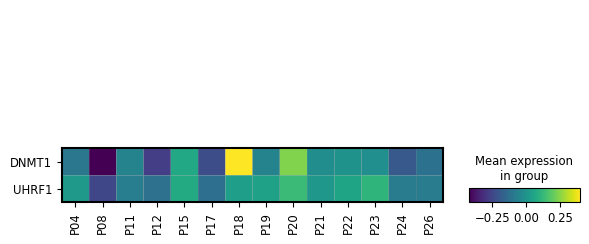

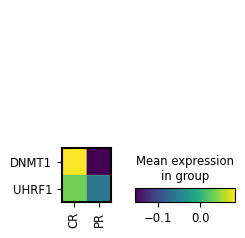

In [43]:
sc.pl.matrixplot(adata[adata.obs['cell_type_isTumor']=='Tumor'], var_names=['DNMT1', 'UHRF1', ], groupby='PatientID', swap_axes=True, layer='scaled')
sc.pl.matrixplot(adata[adata.obs['cell_type_isTumor']=='Tumor'], var_names=['DNMT1', 'UHRF1',], groupby='Response', swap_axes=True, layer='scaled')

In [47]:
merged = sc.read_10x_h5('/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/Tumor_merged/P12-T-I/outs/filtered_feature_bc_matrix.h5')

a1 = sc.read_10x_h5('/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/Tumor/HRR1373220/outs/filtered_feature_bc_matrix.h5')
a2 = sc.read_10x_h5('/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/Tumor/HRR1373219/outs/filtered_feature_bc_matrix.h5')
a3 = sc.read_10x_h5('/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/Tumor/HRR1373218/outs/filtered_feature_bc_matrix.h5')
a4 = sc.read_10x_h5('/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/Tumor/HRR1373217/outs/filtered_feature_bc_matrix.h5')

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-pac

In [72]:
chen_cell_metadata[chen_cell_metadata['Ident']=='CRC12-T-I']

,orig.ident,nCount_RNA,nFeature_RNA,Ident,Patient,Treatment,Tissue,MajorCellType,SubCellType,CB
CRC12-T-I_AAACCTGGTGGACGAT,SeuratProject,1769,654,CRC12-T-I,P12,I,Tumor,Epi,c91_Epi_Tumor,AAACCTGGTGGACGAT
CRC12-T-I_AAAGCAAAGAACAATC,SeuratProject,18800,4055,CRC12-T-I,P12,I,Tumor,Epi,c85_Coloncyte_SLC26A3,AAAGCAAAGAACAATC
CRC12-T-I_AAAGCAACAGATCCAT,SeuratProject,2723,951,CRC12-T-I,P12,I,Tumor,Epi,c84_Coloncyte_CA2,AAAGCAACAGATCCAT
CRC12-T-I_AACACGTAGATGCCTT,SeuratProject,5326,2363,CRC12-T-I,P12,I,Tumor,Epi,c91_Epi_Tumor,AACACGTAGATGCCTT
CRC12-T-I_AACCGCGAGAGCCCAA,SeuratProject,3368,1280,CRC12-T-I,P12,I,Tumor,Epi,c91_Epi_Tumor,AACCGCGAGAGCCCAA
...,...,...,...,...,...,...,...,...,...,...
CRC12-T-I_GGTGCGTTCGAGAACG,SeuratProject,1525,902,CRC12-T-I,P12,I,Tumor,ILC,c34_ILC_NR4A2,GGTGCGTTCGAGAACG
CRC12-T-I_TTAACTCCAAGTAATG,SeuratProject,1453,899,CRC12-T-I,P12,I,Tumor,ILC,c34_ILC_NR4A2,TTAACTCCAAGTAATG
CRC12-T-I_TTGAACGAGCGTAATA,SeuratProject,1778,926,CRC12-T-I,P12,I,Tumor,ILC,c34_ILC_NR4A2,TTGAACGAGCGTAATA
CRC12-T-I_TTGGAACGTCCTCCAT,SeuratProject,952,627,CRC12-T-I,P12,I,Tumor,ILC,c34_ILC_NR4A2,TTGGAACGTCCTCCAT


In [56]:
sc.pp.calculate_qc_metrics(
    merged, inplace=True, log1p=True
)

In [57]:
sc.pp.calculate_qc_metrics(
    a1, inplace=True, log1p=True
)
sc.pp.calculate_qc_metrics(
    a2, inplace=True, log1p=True
)
sc.pp.calculate_qc_metrics(
    a3, inplace=True, log1p=True
)
sc.pp.calculate_qc_metrics(
    a4, inplace=True, log1p=True
)

In [74]:
merged.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACCTGAGCCTATGT-1,840,6.734592,1433.0,7.268223,33.845080,42.428472,55.338451,76.273552
AAACCTGCAGACACTT-1,2406,7.786136,5229.0,8.562166,22.107478,30.502964,40.906483,57.582712
AAACCTGGTGGACGAT-1,918,6.823286,2132.0,7.665285,49.296435,57.317073,66.322702,80.393996
AAACCTGTCAAACGGG-1,719,6.579251,1380.0,7.230563,47.536232,54.782609,62.391304,84.130435
AAACGGGAGCCACTAT-1,573,6.352629,854.0,6.751101,35.831382,44.613583,56.323185,91.451991
...,...,...,...,...,...,...,...,...
TTTGTCAAGGTGACCA-1,480,6.175867,869.0,6.768493,48.101266,56.271577,67.779056,100.000000
TTTGTCAAGTCTCAAC-1,1194,7.085901,14191.0,9.560433,85.582411,88.337679,91.332535,95.109576
TTTGTCACAGATCCAT-1,1704,7.441320,3827.0,8.250098,26.156258,37.209302,49.124641,67.023778
TTTGTCATCCTGCTTG-1,78,4.369448,559.0,6.327937,94.991055,100.000000,100.000000,100.000000


In [96]:
np.mean(chen_cell_metadata[chen_cell_metadata['Ident']=='CRC12-T-I']['nCount_RNA'])
dict_CB_to_nCount = dict()
for tup in chen_cell_metadata[(chen_cell_metadata['Ident']=='CRC12-T-I')].itertuples():
    dict_CB_to_nCount[tup.CB] = [tup.nCount_RNA]
    
for tup in merged.obs.itertuples():
    try: dict_CB_to_nCount[tup.Index.split("-")[0]].append(tup.total_counts)
    except KeyError: continue 
    
dict_CB_to_nCount = { k:v for k,v in dict_CB_to_nCount.items() if len(v)==2 }
dict_CB_to_nCount = pd.DataFrame.from_dict(dict_CB_to_nCount).T
dict_CB_to_nCount.columns = ['author', 'manual']